# Project description
The project presents the solution of machine learning contest organized at Skoltech by Softline company. The solution was provided by Skoltech students Egor Gladin, Semyon Glushkov and Jamil Zakirov and was **awarded the 2nd place** (see [kaggle profile](https://www.kaggle.com/egorgladin/competitions)).

**Contest task:** predict weekly income of [softline online shop](https://store.softline.ru/) for multiple categories.<br>
**Dataset:** sales in the period from 2015-11-01 till 2019-12-31 excluding 11 weeks for which the income should be predicted:<br>
from 2019-03-25 till 2019-03-31,<br>
from 2019-04-22 till 2019-04-28,<br>
from 2019-05-27 till 2019-06-02,<br>
from 2019-06-24 till 2019-06-30,<br>
from 2019-07-22 till 2019-07-28,<br>
from 2019-08-26 till 2019-09-01,<br>
from 2019-09-23 till 2019-09-29,<br>
from 2019-10-21 till 2019-10-27,<br>
from 2019-11-25 till 2019-12-01,<br>
from 2019-12-16 till 2019-12-22,<br>
from 2020-01-06 till 2020-01-12.

For each of these weeks, **the following values should predicted:** *full_discount_price* and *full_price* aggregated for each of 38 popular stores (indicated by *market_id*), for each of 46 popular categories (indicated by *category_id*) and for each of 43 popular vendors (indicated by *vendors_id*) and also total income (including less popular stores, categories and vendors). <br>
Thus, we have (38 + 46 + 43 + 1) $\cdot$ 2 = 256 values to predict for each missing week (multiplication by 2 is because we predict both *full_discount_price* and *full_price*).

**Metric:** RMSE

# Dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/bin/bash: line 0: cd: drive/My Drive/Softline contest: No such file or directory


In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import datetime as dt
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

import os, sys
sys.path.append('/content/drive/My Drive/Softline contest')

In [0]:
os.chdir('/content/drive/My Drive/Softline contest')

**Load dataset**

In [0]:
df_public = pd.read_csv("df_public.csv", index_col=0)
df_public["create_date"]=pd.to_datetime(df_public.create_date).dt.date
df_public = df_public.sort_values(by="create_date")
print(df_public.shape)
df_public.head()

**Perform preprocessing**

In [0]:
from data_preprocessing import get_preprocessed_data, get_aggregated_data

preprocessed_data = get_preprocessed_data('df_public.csv')
agg_data = get_aggregated_data(preprocessed_data)
result_order = pd.read_csv("result_order.csv", index_col=0)

Read original dataset (1/8)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (16,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Drop unnecessary columns (2/8)
Columns to be dropped:
	Unnamed: 0
	boxweight
	country_id
	currency_id
	currency_name
	delivery_date
	delivery_date
	discount_percent
	dostavlen
	full_price_in_order_currency
	group_id
	locale
	nds
	nds_percent
	order_item_id
	payment_date
	payment_is_auto
	payment_is_error
	price
	price_group_id
	ratio2rub
	ratio2rub_official
	ratio2ue
	ratio2ue_official
	refund_date
	region
	shop_id
	subscription_type
	update_date
	zone
Change columns datatypes (3/8)
Drop rare status and STATUS column (4/8)
Drop outliers in data (5/8)
Drop price_with_discount, price_wo_discount columns and discount_price (6/8)
Change column types (7/8)
Drop if full_price is zero (8/8)


  0%|          | 0/1452 [00:00<?, ?it/s]/content/drive/My Drive/Softline contest/data_preprocessing.py:151: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  agg_df = agg_df.loc[bound_dict[column]].reset_index()
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
100%|██████████| 1452/1452 [07:07<00:00,  2.88it/s]


In the following cell the **preprocessed dataset** is transformed in a way that it has **256 columns** that correspond to values that should be predicted (see task description) and **1534 rows**, each row corresponding to a day in the time period from 2015-11-01 till 2020-01-12. Missing values are replaced with NaNs.

The **column names consist of 4 parts** divided by dash. First three parts have the form *market_id-category_id-vendor_id* and include either 3 nans or one number and 2 nans. The first scenario corresponds to total income, the second corresponds to a particular aggregation (e.g. *104448-nan-nan* indicates that income was aggregated by *market_id* = 104448). The last part of the column name indicates whether it is price with or without discount.

In [0]:
import create_time_series
df_full = create_time_series.add_nans(agg_data, result_order, n_target_values=128)
time_series = create_time_series.dataset_to_timeseries(df_full)
time_series.head()

/content/drive/My Drive/Softline contest/create_time_series.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  replacement.create_date[replacement.create_date == dates_replace[i]] = missing_dates[i]
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/content/drive/My Drive/Softline contest/create_time_series.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

(1534, 256) 
 104448-nan-nan-full_discount_price    77
106703-nan-nan-full_discount_price    77
105935-nan-nan-full_discount_price    77
105036-nan-nan-full_discount_price    77
104524-nan-nan-full_discount_price    77
                                      ..
nan-nan-44-full_price                 77
nan-nan-104106-full_price             77
nan-nan-38-full_price                 77
nan-nan-30-full_price                 77
nan-nan-nan-full_price                77
Length: 256, dtype: int64


,104448-nan-nan-full_discount_price,106703-nan-nan-full_discount_price,105935-nan-nan-full_discount_price,105036-nan-nan-full_discount_price,104524-nan-nan-full_discount_price,103244-nan-nan-full_discount_price,102725-nan-nan-full_discount_price,106563-nan-nan-full_discount_price,104768-nan-nan-full_discount_price,100031-nan-nan-full_discount_price,314-nan-nan-full_discount_price,104374-nan-nan-full_discount_price,310-nan-nan-full_discount_price,299-nan-nan-full_discount_price,105503-nan-nan-full_discount_price,105375-nan-nan-full_discount_price,105502-nan-nan-full_discount_price,105498-nan-nan-full_discount_price,103961-nan-nan-full_discount_price,276-nan-nan-full_discount_price,106130-nan-nan-full_discount_price,103952-nan-nan-full_discount_price,104335-nan-nan-full_discount_price,106376-nan-nan-full_discount_price,106629-nan-nan-full_discount_price,104837-nan-nan-full_discount_price,104705-nan-nan-full_discount_price,100610-nan-nan-full_discount_price,103297-nan-nan-full_discount_price,105701-nan-nan-full_discount_price,105702-nan-nan-full_discount_price,107313-nan-nan-full_discount_price,103529-nan-nan-full_discount_price,105071-nan-nan-full_discount_price,105072-nan-nan-full_discount_price,105970-nan-nan-full_discount_price,104572-nan-nan-full_discount_price,103664-nan-nan-full_discount_price,nan-247-nan-full_discount_price,nan-240-nan-full_discount_price,...,nan-nan-17-full_price,nan-nan-103436-full_price,nan-nan-139-full_price,nan-nan-3847-full_price,nan-nan-264-full_price,nan-nan-1799-full_price,nan-nan-28-full_price,nan-nan-31-full_price,nan-nan-34-full_price,nan-nan-36-full_price,nan-nan-104573-full_price,nan-nan-2291-full_price,nan-nan-1645-full_price,nan-nan-1257-full_price,nan-nan-3686-full_price,nan-nan-1639-full_price,nan-nan-1638-full_price,nan-nan-4321-full_price,nan-nan-610-full_price,nan-nan-97-full_price,nan-nan-3806-full_price,nan-nan-735-full_price,nan-nan-2654-full_price,nan-nan-2648-full_price,nan-nan-1624-full_price,nan-nan-728-full_price,nan-nan-599-full_price,nan-nan-2763-full_price,nan-nan-1740-full_price,nan-nan-330-full_price,nan-nan-104008-full_price,nan-nan-3134-full_price,nan-nan-59-full_price,nan-nan-49-full_price,nan-nan-301-full_price,nan-nan-44-full_price,nan-nan-104106-full_price,nan-nan-38-full_price,nan-nan-30-full_price,nan-nan-nan-full_price
create_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-11-01,6197.0,0.0,0.0,8095.0,1874.0,51345.0,5982.0,0.0,17933.0,498450.0,2649.0,0.0,19085.0,617.0,0.0,0.0,0.0,0.0,3790701.0,4194.0,0.0,151500.0,33223.0,0.0,0.0,55085.0,938199.0,991.0,158026.0,0.0,0.0,0.0,31470.0,2200.0,500.0,0.0,0.0,5617.0,0.0,0.0,...,19850.0,0.0,0.0,0.0,2200.0,0.0,59225.0,509733.0,0.0,1988.0,0.0,25815.0,990.0,0.0,4980.0,0.0,36517.0,3750.0,0.0,0.0,0.0,57825.0,0.0,1950.0,55450.0,2202114.0,5617.0,2400.0,0.0,0.0,5982.0,6197.0,76407.0,2500.0,3500.0,0.0,20475.0,17860.0,3841035.0,7030916.0
2015-11-02,999.0,0.0,0.0,6852.0,8503.0,66315.0,10441.0,0.0,12922.0,581449.0,13040.0,0.0,13492.0,3692.0,0.0,0.0,0.0,0.0,3893616.0,12230.0,0.0,138900.0,45090.0,0.0,0.0,41851.0,811346.0,22933.0,329323.0,0.0,0.0,0.0,30899.0,8800.0,1950.0,0.0,3900.0,4245.0,0.0,0.0,...,28480.0,0.0,0.0,580.0,8800.0,0.0,123417.0,618109.0,0.0,2687.0,0.0,9185.0,4470.0,0.0,2490.0,0.0,40768.0,3500.0,17036.0,0.0,0.0,78285.0,0.0,0.0,69494.0,1947646.0,7593.0,2400.0,0.0,3900.0,10441.0,999.0,50060.0,0.0,11630.0,0.0,10350.0,27780.0,3985735.0,7229342.0
2015-11-03,0.0,0.0,0.0,1800.0,1970.0,60810.0,6824.0,0.0,16113.0,475855.0,4495.0,2490.0,4275.0,0.0,0.0,0.0,0.0,0.0,3641376.0,12009.0,0.0,138400.0,35158.0,0.0,0.0,30920.0,788799.0,14981.0,325049.0,0.0,0.0,0.0,23900.0,3740.0,1000.0,0.0,0.0,12419.0,0.0,0.0,...,3980.0,4320.0,0.0,8990.0,3740.0,0.0,114298.0,520789.0,0.0,2200.0,0.0,2605.0,1490.0,900.0,12077.0,0.0,33105.0,2000.0,14981.0,0.0,3000.0,73905.0,0.0,0.0,48763.0,1881606.0,12439.0,4799.0,0.0,0.0,6824.0,0.0,38070.0,0.0,8939.0,0.0,2785.0,14860.0,3756074.0,6722694.0
2015-11-04,2999.0,0.0,0.0,2072.0,

As said earlier, dataset includes NaNs for missing weeks, i.e. (11 weeks) $\cdot$ (7 days) = **77 NaNs per column:**

In [0]:
print(time_series.shape, '\n', time_series.isnull().sum())

## Visualization

In [0]:
def plot_time_series(dataset, first_day=0, last_day=100, vlines_step=7, ACF=False):
    n_series = dataset.shape[1]
    n_days = last_day - first_day
    
    plt.figure(figsize=(15, 2 * n_series))
    for i in range(n_series):
        plt.subplot(n_series, 1, i + 1)
        if ACF:
            max_lag = int(n_days * 0.95)
            autocorr = [dataset.iloc[first_day:last_day, i].autocorr(lag=j) for j in range(max_lag)]
            plt.plot(autocorr)
            plt.xlim(0, max_lag - 1)
            plt.xticks(range(0, max_lag - 1, vlines_step))
        else:
            plt.plot(dataset.iloc[first_day:last_day, i].reset_index(drop=True))
            plt.xlim(0, n_days - 1)
            plt.ylim(0)
            plt.xticks(range(0, n_days - 1, vlines_step))

        for xc in range(vlines_step, n_days - 1, vlines_step):
            plt.axvline(x=xc, color='g')
    title = 'ACF' if ACF else 'values'
    plt.suptitle(f'Time series {title}', fontsize=15)
    plt.subplots_adjust(top=0.95)

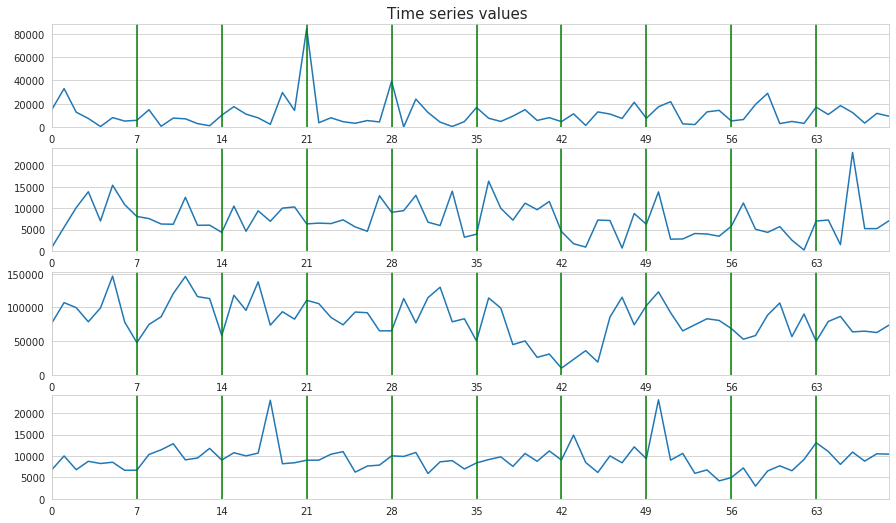

In [0]:
plot_time_series(time_series.iloc[:, 3:7], first_day=70, last_day=140)

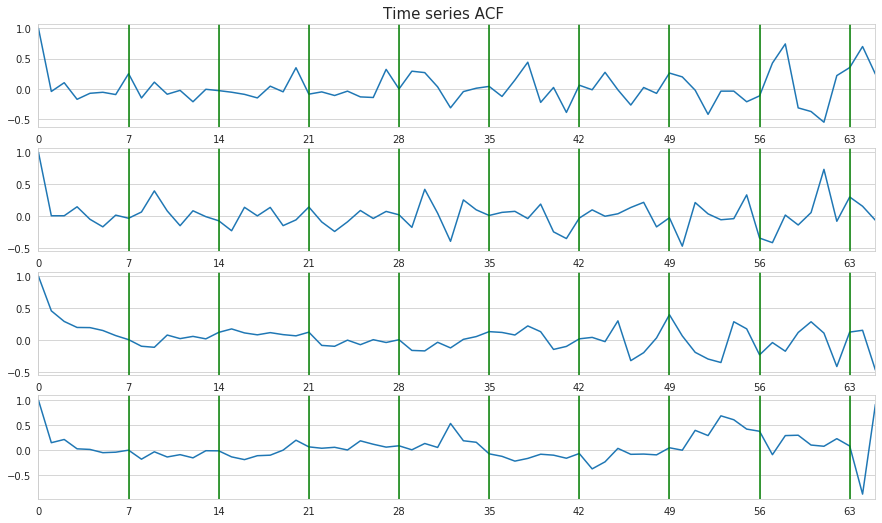

In [0]:
plot_time_series(time_series.iloc[:, 3:7], first_day=70, last_day=140, ACF=True) # Autocorrelation Function (ACF)

**No weekly periodicity observed.**

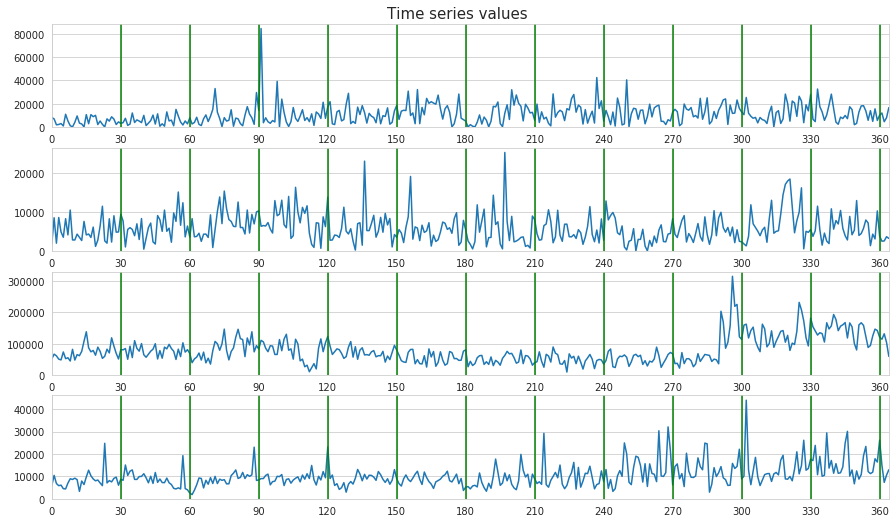

In [0]:
plot_time_series(time_series.iloc[:, 3:7], first_day=0, last_day=365, vlines_step=30)

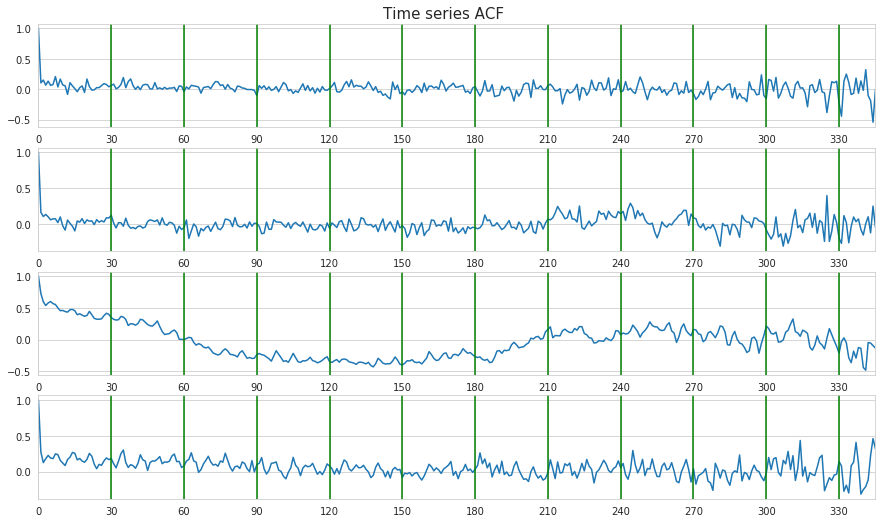

In [0]:
plot_time_series(time_series.iloc[:, 3:7], first_day=0, last_day=365, vlines_step=30, ACF=True) # Autocorrelation Function (ACF)

**No monthly periodicity in these series either.**

# ARIMA model
As one of the popular classical models for time series, ARIMA was chosen.

In [0]:
# this cell deals with the file that describes the format of results to be
# submitted to kaggle, hence it's not vital for understanding of the solution
result_order = pd.read_csv('result_order.csv', index_col=0)

def create_ultimate_id(x):
    return f'{x.market_id:.0f}-{x.category_id:.0f}-{x.vendor_id:.0f}-{x.target_type}'

result_order['ultimate_id'] = result_order.apply(create_ultimate_id, axis=1)

In [0]:
# ARIMA model works better with dataframes that have DatetimeIndex with valid frequency
time_series.index = pd.DatetimeIndex(time_series.index.values)
time_series.index = pd.DatetimeIndex(time_series.index.values, freq=time_series.index.inferred_freq)

In [0]:
# these parameters for ARIMA model were chosen empirically
order = (4, 1, 2)

# when the parameters above do not work, the following are used
alternative_order = (5, 0, 1)

# dict for models corresponding to each of 256 time series
models = {}

# dict for predictions of models for each week
preds = {}

for row in tqdm(result_order.iterrows()): # tqdm for progress tracking
    
    idx, value = row
    
    # fd and ld stand for first day and last day (of the week to be predicted)
    fd = dt.datetime.strptime(value.dates[1:11], '%Y-%m-%d').date()
    ld = fd + dt.timedelta(6)
    
    # determine which of 256 time series should be dealt with on this iteration
    market_id = value.market_id
    category_id = value.category_id
    vendor_id = value.vendor_id
    target_type = value.target_type
    
    # column name in the dataset that corresponds to the determined time series
    my_id = f'{market_id:.0f}-{category_id:.0f}-{vendor_id:.0f}-{target_type}'
    
    # create model for this time series
    if not (my_id in models):
        try:
            model = SARIMAX(time_series[my_id], order=order, missing='drop')
            model_fit = model.fit()
            models[my_id] = model_fit
        
        # sometimes SARIMAX fails with the parameters above
        except:
            model = SARIMAX(time_series[my_id], order=alternative_order, missing='drop')
            model_fit = model.fit()
            models[my_id] = model_fit

    # prediction of particular value for particular week is saved
    preds[idx] = models[my_id].predict(start=fd, end=ld, dynamic=True).sum()

2816it [10:49,  4.33it/s]


In [0]:
# create file for submission to kaggle
sub = pd.read_csv('sample_submission.csv', index_col='index')
predictions = sub.copy()

for row in result_order.iterrows():
    idx, value = row
    predictions.loc[idx, 'target'] = preds[idx]

predictions.to_csv(f'submit_me.csv')
print('Submission is saved')

Submission is saved


# Heuristic
One of the missing weeks was a Black Friday week. Jamil noticed, that during this week the income is higher and proposed to multiply ARIMA's prediction for this week by a factor in interval (1, 2). The trick increased the performance and brought our team to the 2nd position in a leaderboard. The model itself couldn't recognize this rare pattern.

In [0]:
black_friday_scale = 1.1
black_friday_date = dt.datetime(2019, 11, 29)
predictions = pd.read_csv('submit_me.csv', index_col=0)

In [0]:
nrows = 0
for row in predictions.iterrows():
    idx, value = row
    fd = dt.datetime.strptime(idx[1:11], '%Y-%m-%d')
    ld = fd + dt.timedelta(days=6)
    if fd <= black_friday_date <= ld:
        nrows += 1
        predictions.loc[idx, 'target'] = value.target * black_friday_scale
print(f'Number of changed rows: {nrows}')
predictions.to_csv('submit_me_black_friday_hack.csv')
print('Modified submission is saved')

Number of changed rows: 256
Modified submission is saved
